# Drogued VS undrogued + Ekman at surface VS at 15m

In [1]:
import numpy as np
import pandas as pd
import xarray as xr

import os
from glob import glob

import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms

import histlib.matchup as match
import histlib.diagnosis as diag
from histlib.cstes import labels, zarr_dir, matchup_dir, var
from histlib.matchup import _data_var, _stress_var, _aviso_var

/home1/datahome/mdemol/.miniconda3/envs/histenv2/lib/python3.9/site-packages/dask/config.py:742: FutureWarning: Dask configuration key 'distributed.scheduler.transition-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
  warnings.warn(
/home1/datahome/mdemol/.miniconda3/envs/histenv2/lib/python3.9/site-packages/dask/config.py:742: FutureWarning: Dask configuration key 'distributed.comm.recent-messages-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
  warnings.warn(


In [2]:
zarr_dir

'/home/datawork-lops-osi/aponte/margot/historical_coloc'

In [3]:
DL =25*1e3 #meters
DT = 0.5*3600 #seconds
id_aviso = 'aviso__25__adt__es_cstrio_z15__alti_x'
id_co = 'co__25__adt_filtered_ocean_tide_internal_tide__es_cstrio_z15__drifter_x'

In [4]:
def global_ms_drifter_sat_year(dsms):
    ds = (((dsms*dsms.nb_coloc).sum('drifter_sat_year'))/(dsms.nb_coloc.sum('drifter_sat_year'))).drop('nb_coloc')
    print(dsms.nb_coloc.sum('drifter_sat_year'))
    for v in dsms.keys():
        if v != 'nb_coloc':
            ds[v].attrs=dsms[v].attrs
    return ds

def put_fig_letter(ax, letter):
    trans = mtransforms.ScaledTranslation(10/72, -5/72, fig.dpi_scale_trans)
    ax.text(0.0, 1.0, letter+')', transform=ax.transAxes+trans,
            fontsize='medium', verticalalignment='top', fontfamily='serif',
            bbox=dict(facecolor='0.7', edgecolor='none', pad=3.0))

________
# Datasets 

In [5]:
dsd = xr.open_dataset(os.path.join(zarr_dir+'_ok','global', f'ms_{int(DL//1000)}_{DT}_drogued.zarr'))
dsud = xr.open_dataset(os.path.join(zarr_dir+'_ok','global', f'ms_{int(DL//1000)}_{DT}_undrogued.zarr'))

gps = [l for l in dsd.drifter_sat_year.values if 'gps' in l]
argos = [l for l in dsd.drifter_sat_year.values if 'argos' in l]
dsg = global_ms_drifter_sat_year(dsd.sel(drifter_sat_year=gps)).persist()
dsa = global_ms_drifter_sat_year(dsd.sel(drifter_sat_year=argos)).persist()

gps = [l for l in dsud.drifter_sat_year.values if 'gps' in l]
argos = [l for l in dsud.drifter_sat_year.values if 'argos' in l]
dsug = global_ms_drifter_sat_year(dsud.sel(drifter_sat_year=gps)).persist()
dsua = global_ms_drifter_sat_year(dsud.sel(drifter_sat_year=argos)).persist()

<xarray.DataArray 'nb_coloc' ()>
array(146030)
<xarray.DataArray 'nb_coloc' ()>
array(91830)
<xarray.DataArray 'nb_coloc' ()>
array(159148)
<xarray.DataArray 'nb_coloc' ()>
array(161561)


______________________
# Drogued VS undrogued 
## Residual

In [6]:
def compute_sum_ms(ds, id_):
    dic = ds['sum_'+id_].attrs
    return ds[dic['acc']]+ds[dic['coriolis']]+ds[dic['ggrad']]+ds[dic['wind']]
def RSE_id(ds, id_):
    dic = ds['sum_'+id_].attrs
    acc = ''+dic['acc']
    cor = ''+dic['coriolis']
    ggrad = ''+dic['ggrad']
    wd = ''+dic['wind']
    return (ds['sum_'+id_]/(ds[acc]+ds[cor]+ds[ggrad]+ds[wd])).values*100

In [7]:
print('Along-track -GPS : drogued')
print('S2 = ' + f"{dsg['sum_'+id_co].values}")
print(f"RSE = {RSE_id(dsg, id_co)}")
print('Along-track -GPS: undrogued')
print('S2 = ' + f"{dsug['sum_'+id_co].values}")
print(f"RSE = {RSE_id(dsug, id_co)}")


Along-track -GPS : drogued
S2 = 1.5534432205925074e-10
RSE = 19.388954794635538
Along-track -GPS: undrogued
S2 = 2.4159630812209996e-10
RSE = 25.9815348366364


Text(0, 0.5, '$\\langle S^2 \\rangle$ $[m^2/s^4]$')

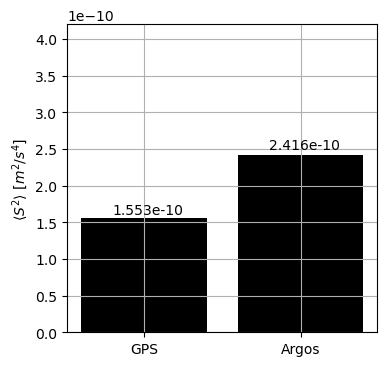

In [8]:
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(4,4))

ax.bar(0.5, dsg['sum_'+id_co], color ='k',width = 0.4)
ax.bar(1, dsug['sum_'+id_co], color ='k',width = 0.4)
ax.text(0.4, dsg['sum_'+id_co]+dsg['sum_'+id_co]/30, str(np.format_float_scientific(dsg['sum_'+id_co].values,precision = 3)))
ax.text(0.9, dsug['sum_'+id_co]+dsug['sum_'+id_co]/30, str(np.format_float_scientific(dsug['sum_'+id_co].values,precision = 3)))

ax.grid()
ax.set_ylim(0,4.2e-10)
ticks = ('GPS', 'Argos')
ax.set_xticks([0.5, 1], ticks,)
ax.set_ylabel(r'$\langle S^2 \rangle$ $[m^2/s^4]$')

Text(0, 0.5, '$RSE$ [%]')

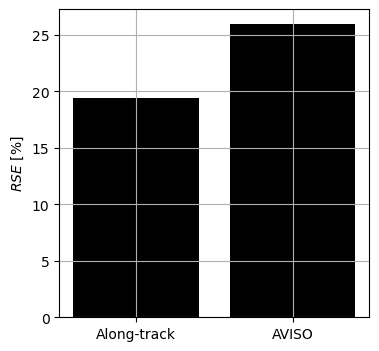

In [9]:
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(4,4))

ax.bar(0.5, RSE_id(dsg, id_co), color ='k',width = 0.4)
ax.bar(1, RSE_id(dsug, id_co), color ='k',width = 0.4)

ax.grid()

ticks = ('Along-track', 'AVISO')
ax.set_xticks([0.5, 1], ticks,)
ax.set_ylabel(r'$RSE$ [%]')

In [10]:
def compute_sum_ms(ds, id_):
    dic = ds['sum_'+id_].attrs
    return ds[dic['acc']]+ds[dic['coriolis']]+ds[dic['ggrad']]+ds[dic['wind']]
def RC_x(ds, id_):
    if isinstance(id_, str):
        dic = ds['sum_'+id_].attrs
        lab = ['acc', 'coriolis', 'ggrad', 'wind']
        s = compute_sum_ms(ds, id_)
        df = pd.DataFrame({l:((ds['exc_'+l+'_'+id_] - ds['sum_'+id_])/s).values for l in lab}, index=pd.Index([id_], name='id_comb'))
    else :
        D =[]
        DN = []
        for id__ in id_ :
            dic = ds['sum_'+id__].attrs
            lab = ['acc', 'coriolis', 'ggrad', 'wind']
            s = compute_sum_ms(ds, id__)
            D.append(pd.DataFrame({l:((ds['exc_'+l+'_'+id__] - ds['sum_'+id__])).values for l in lab}, index=pd.Index([id__], name='id_comb')))
            DN.append(pd.DataFrame({l:((ds['exc_'+l+'_'+id__] - ds['sum_'+id__])/s).values for l in lab}, index=pd.Index([id__], name='id_comb')))
        df=pd.concat(D)
        dfn=pd.concat(DN)
    return df, dfn

________________________
# True/Error in $x$ 

In [11]:
def true_err_x(ds, id_) :
    dso = xr.Dataset()
    dic = ds['sum_'+id_].attrs
    for x in ['acc', 'coriolis', 'ggrad', 'wind']:
        X =dic[x]
        dso[x] = ds[X]
        dso['exc_'+x] = ds['exc_' + x +'_'+ id_]
        dso['true_'+x] = (ds[X] - ds['sum_'+id_] + ds['exc_' + x +'_'+ id_])/2
        dso['err_'+x] = (ds[X] + ds['sum_'+id_] - ds['exc_' + x +'_'+ id_])/2
    dso['S'] = ds['sum_'+id_]
    return dso
dsmsug = xr.concat([true_err_x(dsug, id_co), true_err_x(dsug, id_aviso)], dim=pd.Index([id_co, id_aviso], name = 'id_comb'))
dsmsg = xr.concat([true_err_x(dsg, id_co), true_err_x(dsg, id_aviso)], dim=pd.Index([id_co, id_aviso], name = 'id_comb'))

In [12]:
def plot_cor_uncor_part(ds, ax, title=None):
    """ 
    Parameters
    ----------
    ds : dataset with rms of x, excx and sum (created by )
    id_: identification of the combination
    ax : axis on which to plot

    """
    # ACC X
    ax.bar(1.5, ds['true_acc'],
           color = 'k', width = 0.4, zorder=3, align = 'center')
    ax.bar(1.5, ds['err_acc'], bottom = ds['true_acc'],
           color = 'lightgrey', width = 0.4, zorder=3, align = 'center')
    ax.text(1.5, ds['acc']+5e-12, str(np.format_float_scientific(ds['acc'].values,precision = 3)), horizontalalignment='center')
    rse = np.round(ds['true_acc']/ds['acc']*100,2)
    ax.text(1.5, ds['true_acc']+5e-12, f'{rse.values}%', horizontalalignment='center')

    # CORIOLIS
    ax.bar(2, ds['true_coriolis'],
           color = 'k', width = 0.4, zorder=3, align = 'center')
    ax.bar(2, ds['err_coriolis'], bottom = ds['true_coriolis'],
           color = 'lightgrey', width = 0.4, zorder=3, align = 'center')
    ax.text(2, ds['coriolis']+5e-12, str(np.format_float_scientific(ds['coriolis'].values,precision = 3)), horizontalalignment='center')
    rse = np.round(ds['true_coriolis']/ds['coriolis']*100,2)
    ax.text(2, ds['true_coriolis']+5e-12, f'{rse.values}%', horizontalalignment='center')

    # G GRADIENT SLA
    ax.bar(2.5, ds['true_ggrad'],
           color = 'k', width = 0.4, zorder=3, align = 'center')
    ax.bar(2.5, ds['err_ggrad'], bottom = ds['true_ggrad'],
           color = 'lightgrey', width = 0.4, zorder=3, align = 'center')
    ax.text(2.5, ds['ggrad']+5e-12, str(np.format_float_scientific(ds['ggrad'].values,precision = 3)), horizontalalignment='center')
    rse = np.round(ds['true_ggrad']/ds['ggrad']*100,2)
    ax.text(2.5, ds['true_ggrad']+5e-12, f'{rse.values}%', horizontalalignment='center')

        # WIND
    ax.bar(3, ds['true_wind'],
           color = 'k', width = 0.4, zorder=3, align = 'center')
    ax.bar(3, ds['err_wind'], bottom = ds['true_wind'],
           color = 'lightgrey', width = 0.4, zorder=3, align = 'center')
    ax.text(3, ds['wind']+5e-12, str(np.format_float_scientific(ds['wind'].values,precision = 3)), horizontalalignment='center')
    rse = np.round(ds['true_wind']/ds['wind']*100,2)
    ax.text(3, ds['true_wind']+5e-12, f'{rse.values}%', horizontalalignment='center')

    #ax.set_ylim((0,8e-5))
    ax.grid(axis='y', zorder=0)

    if isinstance(title, int): ax.set_title(ds.id_comb)
    else : ax.set_title(title+'\n')
    
    N=np.arange(1.5,3.5, 0.5) 
    ticks = (r'$d_tu$', r'$-fv$', r'$g \partial_x \eta$', r'$\frac{1}{\rho}\partial_z\tau_x$')
    ax.set_xticks(N, ticks,)

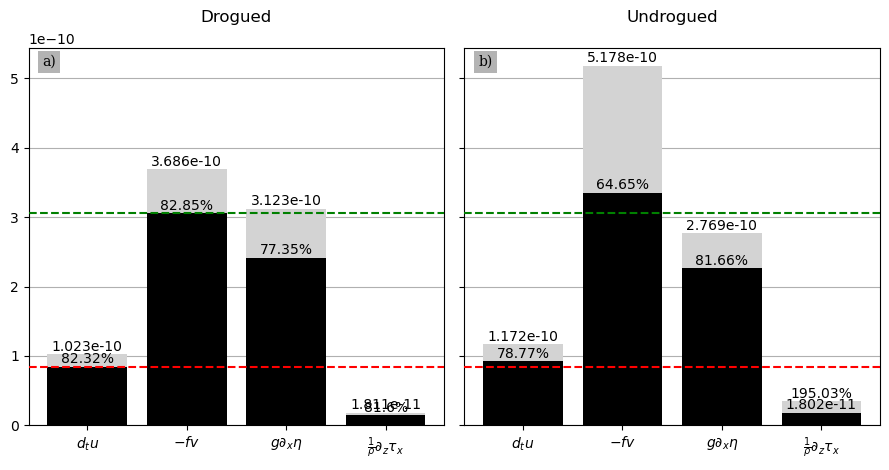

In [13]:
fig_title=1
fig, axs = plt.subplots(nrows=1,ncols=2,
                            sharey='all',
                            figsize=(9,6))
plot_cor_uncor_part(dsmsg.sel(id_comb=id_co), ax=axs[0], title ='Drogued')
plot_cor_uncor_part(dsmsug.sel(id_comb=id_co), ax=axs[1], title ='Undrogued')
axs[0].axhline(dsmsg.true_acc.sel(id_comb=id_co), ls='--', color='r', zorder=3)
axs[1].axhline(dsmsg.true_acc.sel(id_comb=id_co), ls='--', color='r', zorder=3)
axs[0].axhline(dsmsg.true_coriolis.sel(id_comb=id_co), ls='--', color='g', zorder=3)
axs[1].axhline(dsmsg.true_coriolis.sel(id_comb=id_co), ls='--', color='g', zorder=3)

put_fig_letter(axs[0], 'a')
put_fig_letter(axs[1], 'b')
#fig.legend(handles, labels_, ncol=3,loc='lower center')#, bbox_to_anchor=(1,         0.5))#bbox_transform=fig.transFigure,
fig.tight_layout(rect=[0,0.2,1,1])#left, bottom, right, top (default is 0,0,1,1)

______________________
# Drogued 0 vS 15m
## Residual

In [24]:
print('Along-track -GPS-drogued : 15m')
print('S2 = ' + f"{dsg['sum_'+id_co].values}")
print(f"RSE = {RSE_id(dsg, id_co)}")
print('Along-track -GPS-drogued : 0m')
print('S2 = ' + f"{dsg['sum_'+id_co0].values}")
print(f"RSE = {RSE_id(dsg, id_co0)}")


Along-track -GPS-drogued : 15m
S2 = 1.5534432205925074e-10
RSE = 19.388954794635538
Along-track -GPS-drogued : 0m
S2 = 3.540895998198724e-10
RSE = 39.42237183042705


In [18]:
id_co0 = 'co__25__adt_filtered_ocean_tide_internal_tide__es_cstrio_z0__drifter_x'

In [22]:

dsmsg = xr.concat([true_err_x(dsg, id_co), true_err_x(dsg, id_co0)], dim=pd.Index([id_co, id_co0], name = 'id_comb'))

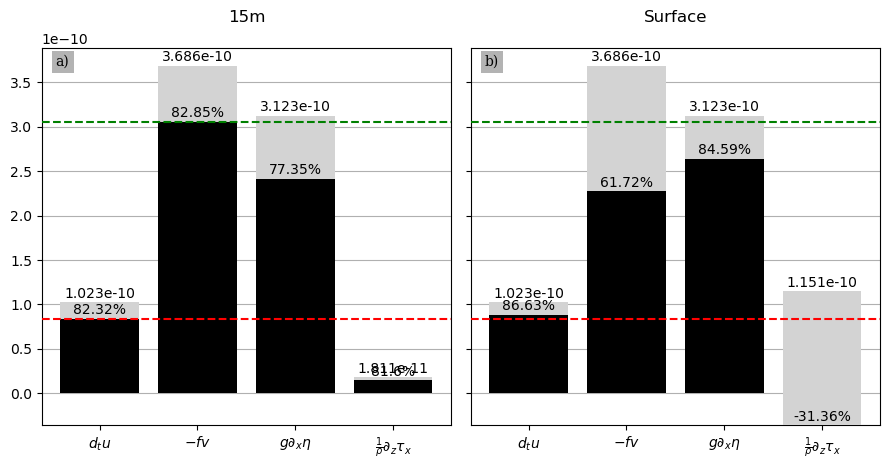

In [23]:
fig_title=1
fig, axs = plt.subplots(nrows=1,ncols=2,
                            sharey='all',
                            figsize=(9,6))
plot_cor_uncor_part(dsmsg.sel(id_comb=id_co), ax=axs[0], title ='15m')
plot_cor_uncor_part(dsmsg.sel(id_comb=id_co0), ax=axs[1], title ='Surface')
axs[0].axhline(dsmsg.true_acc.sel(id_comb=id_co), ls='--', color='r', zorder=3)
axs[1].axhline(dsmsg.true_acc.sel(id_comb=id_co), ls='--', color='r', zorder=3)
axs[0].axhline(dsmsg.true_coriolis.sel(id_comb=id_co), ls='--', color='g', zorder=3)
axs[1].axhline(dsmsg.true_coriolis.sel(id_comb=id_co), ls='--', color='g', zorder=3)

put_fig_letter(axs[0], 'a')
put_fig_letter(axs[1], 'b')
#fig.legend(handles, labels_, ncol=3,loc='lower center')#, bbox_to_anchor=(1,         0.5))#bbox_transform=fig.transFigure,
fig.tight_layout(rect=[0,0.2,1,1])#left, bottom, right, top (default is 0,0,1,1)

______________________
# Undrogued 0 vS 15m
## Residual

In [25]:
print('Along-track -GPS-drogued : 15m')
print('S2 = ' + f"{dsug['sum_'+id_co].values}")
print(f"RSE = {RSE_id(dsug, id_co)}")
print('Along-track -GPS-drogued : 0m')
print('S2 = ' + f"{dsug['sum_'+id_co0].values}")
print(f"RSE = {RSE_id(dsug, id_co0)}")


Along-track -GPS-drogued : 15m
S2 = 2.4159630812209996e-10
RSE = 25.9815348366364
Along-track -GPS-drogued : 0m
S2 = 6.039571167844001e-10
RSE = 58.8375744835647


In [26]:

dsmsg = xr.concat([true_err_x(dsug, id_co), true_err_x(dsug, id_co0)], dim=pd.Index([id_co, id_co0], name = 'id_comb'))

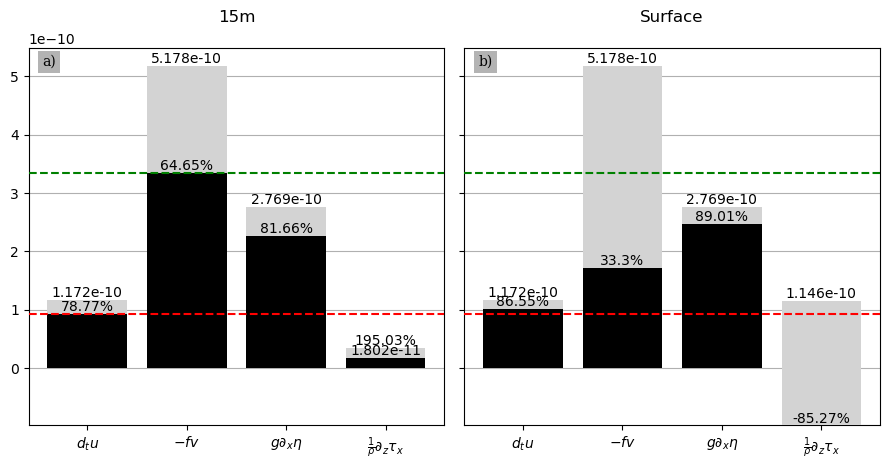

In [27]:
fig_title=1
fig, axs = plt.subplots(nrows=1,ncols=2,
                            sharey='all',
                            figsize=(9,6))
plot_cor_uncor_part(dsmsg.sel(id_comb=id_co), ax=axs[0], title ='15m')
plot_cor_uncor_part(dsmsg.sel(id_comb=id_co0), ax=axs[1], title ='Surface')
axs[0].axhline(dsmsg.true_acc.sel(id_comb=id_co), ls='--', color='r', zorder=3)
axs[1].axhline(dsmsg.true_acc.sel(id_comb=id_co), ls='--', color='r', zorder=3)
axs[0].axhline(dsmsg.true_coriolis.sel(id_comb=id_co), ls='--', color='g', zorder=3)
axs[1].axhline(dsmsg.true_coriolis.sel(id_comb=id_co), ls='--', color='g', zorder=3)

put_fig_letter(axs[0], 'a')
put_fig_letter(axs[1], 'b')
#fig.legend(handles, labels_, ncol=3,loc='lower center')#, bbox_to_anchor=(1,         0.5))#bbox_transform=fig.transFigure,
fig.tight_layout(rect=[0,0.2,1,1])#left, bottom, right, top (default is 0,0,1,1)